# Recommender Systems

Recommender systems are among the most impactful applications of machine learning, driving a large fraction of sales and engagement on platforms like Netflix, Amazon, and others.

## I. Collaborative Filtering

This approach recommends items by identifying patterns in user ratings. The core idea is that users who agreed in the past (rated items similarly) will likely agree in the future.

### Notation
- $n_u$: number of users
- $n_m$: number of movies (items)
- $r(i, j)$: 1 if user $j$ has rated movie $i$, 0 otherwise.
- $y^{(i, j)}$: The rating (e.g., 0-5 stars) given by user $j$ to movie $i$.
- $\vec{x}^{(i)}$: A feature vector describing movie $i$.
- $\vec{w}^{(j)}, b^{(j)}$: Parameters for user $j$.
- $n$: number of features per movie.

### The Algorithm: Learning Features and Parameters Simultaneously
Initially, we can think of this as learning a separate linear regression model for each user, where the prediction for user $j$ on movie $i$ is $\vec{w}^{(j)} \cdot \vec{x}^{(i)} + b^{(j)}$.

However, the real power of collaborative filtering is that we often **don't have the movie features** $\vec{x}^{(i)}$. The key insight is that the algorithm can **learn the features for the movies and the parameters for the users at the same time.**

The overall cost function to minimize is:
$$
J(\vec{x}^{(1)},...,\vec{x}^{(n_m)}, \vec{w}^{(1)},...,\vec{w}^{(n_u)}, b^{(1)},...,b^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( (\vec{w}^{(j)} \cdot \vec{x}^{(i)} + b^{(j)}) - y^{(i,j)} \right)^2 + \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^{n} (w_k^{(j)})^2 + \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^{n} (x_k^{(i)})^2
$$

This function aims to find:
- **User parameters** ($\vec{w}^{(j)}, b^{(j)}$) that describe what kind of movies a user likes.
- **Movie features** ($\vec{x}^{(i)}$) that describe the properties of a movie (e.g., how much romance or action it has).

### Finding Related Items
Once the movie feature vectors $\vec{x}^{(i)}$ are learned, you can find movies similar to movie $i$ by finding movies $k$ where the squared distance $||\vec{x}^{(i)} - \vec{x}^{(k)}||^2$ is small.

### Practical Implementation Details

#### Mean Normalization
This is a crucial preprocessing step that helps with the **cold start problem** (making reasonable predictions for new users who have rated nothing).
1.  For each movie, calculate the average rating $\mu_i$ across all users who have rated it.
2.  Create a new, normalized ratings matrix by subtracting the mean rating from each existing rating: $y_{norm}^{(i,j)} = y^{(i,j)} - \mu_i$.
3.  Train the collaborative filtering algorithm using these normalized ratings.
4.  When making a prediction for user $j$ on movie $i$, add the mean back: $\text{prediction} = \vec{w}^{(j)} \cdot \vec{x}^{(i)} + b^{(j)} + \mu_i$.

For a new user with no ratings, the learned parameters $\vec{w}$ and $b$ will be zero (due to regularization), so their predicted rating for any movie will simply be the movie's average rating, which is a much more reasonable guess than zero.

#### TensorFlow for Collaborative Filtering
Because the collaborative filtering cost function doesn't fit the standard Keras `Sequential` model structure, we need a more fundamental way to perform gradient descent. TensorFlow's **`GradientTape`** is perfect for this. It allows for **automatic differentiation** (autodiff).
1.  Define your parameters ($\vec{w}, b, \vec{x}$) as `tf.Variable`.
2.  Write a function to calculate the cost $J$.
3.  Inside a `with tf.GradientTape() as tape:` block, call your cost function. TensorFlow "records" all the operations.
4.  Call `tape.gradient(J, [params])` to get the gradients of $J$ with respect to your parameters.
5.  Use an optimizer (like `tf.keras.optimizers.Adam`) to apply these gradients to your parameters.

In [5]:
import tensorflow as tf

# Initialize a parameter 'w' as a TensorFlow variable
w = tf.Variable(3.0)

# Define the cost function J = (w*x - y)^2
# For this simple example, let x=1 and y=1
x_train = 1.0
y_train = 1.0

# Use the GradientTape context to "record" the operations
with tf.GradientTape() as tape:
    # Forward pass: calculate the cost
    cost = (w * x_train - y_train)**2

# Calculate the gradient of the cost with respect to 'w'
# This is the automatic differentiation step
grad = tape.gradient(cost, w)

print(f"Initial w: {w.numpy()}")
print(f"Cost: {cost.numpy()}")
print(f"Gradient of cost w.r.t w: {grad.numpy()}")

# We can then use this gradient in an optimizer
# For example, a single step of gradient descent:
learning_rate = 0.1
w.assign_sub(learning_rate * grad) # w = w - alpha * grad
print(f"New w after one step of gradient descent: {w.numpy()}")

Initial w: 3.0
Cost: 4.0
Gradient of cost w.r.t w: 4.0
New w after one step of gradient descent: 2.5999999046325684


## II. Content-Based Filtering with Deep Learning

This is a more modern and powerful approach that uses features about the users and items directly.

| Collaborative Filtering                                     | Content-Based Filtering                                      |
| :---------------------------------------------------------- | :----------------------------------------------------------- |
| Recommends based on what similar users liked.               | Recommends based on features of users and items.             |
| Learns item features from the ratings matrix.               | Requires explicit feature vectors for users and items as input. |
| Suffers from the cold start problem.                        | Handles new items well, as long as they have features.         |

### The Two-Network Architecture
A deep learning model for content-based filtering typically uses two parallel neural networks:
1.  **User Network**: Takes a user feature vector ($x_u$) as input and outputs a user embedding vector ($v_u$).
2.  **Item Network**: Takes an item (movie) feature vector ($x_m$) as input and outputs an item embedding vector ($v_m$).

The final prediction is the **dot product** of these two embedding vectors: $\hat{y} = v_u \cdot v_m$. The entire system is trained end-to-end to minimize a cost function (e.g., Mean Squared Error between the predicted and actual ratings).

![Content-Based Filtering NN](https://i.imgur.com/gKzBfC0.png)

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Concatenate, Dot
from tensorflow.keras.models import Model

# --- Define the User Network ---
# Assume user_features have 128 dimensions
user_input = Input(shape=(128,), name="user_input")
user_nn = Dense(256, activation='relu')(user_input)
user_nn = Dense(128, activation='relu')(user_nn)
user_vector = Dense(32, activation='linear', name="user_vector")(user_nn) # Output is a 32-dim vector

# --- Define the Item (Movie) Network ---
# Assume item_features have 64 dimensions
item_input = Input(shape=(64,), name="item_input")
item_nn = Dense(256, activation='relu')(item_input)
item_nn = Dense(128, activation='relu')(item_nn)
item_vector = Dense(32, activation='linear', name="item_vector")(item_nn) # Output must be same size as user_vector

# --- Compute the Dot Product ---
# The Dot layer takes the two vectors and computes their dot product
dot_product = Dot(axes=1)([user_vector, item_vector])

# --- Create the full model ---
model = Model(inputs=[user_input, item_input], outputs=dot_product)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error')

print("Content-based model created successfully.")
model.summary()

Content-based model created successfully.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     33,024 │ user_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │     16,640 │ item_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     32,896 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_vector (Dense) │ (None, 32)        │      4,128 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_vector (Dense) │ (None, 32)        │      4,128 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 1)         │          0 │ user_vector[0][0… │
│                     │                   │            │ item_vector[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 123,712 (483.25 KB)

 Trainable params: 123,712 (483.25 KB)

 Non-trainable params: 0 (0.00 B)


### Scaling to Millions of Items: Retrieval and Ranking
For a massive catalog, predicting a rating for every item for a single user is computationally infeasible. Large-scale systems use a two-step process:

1.  **Retrieval**: Quickly generate a large list of a few hundred plausible candidates from the millions of items. This step prioritizes speed and broad coverage. Examples:
    - Find items similar to items the user recently interacted with.
    - Find the top items in the user's favorite genres.
2.  **Ranking**: Use the more complex (and slower) deep learning model to score and rank the smaller set of candidates generated by the retrieval step. The top items from this ranked list are then shown to the user.

---
## III. (Optional) Principal Component Analysis (PCA)

PCA is an unsupervised learning algorithm used for **dimensionality reduction**, most often to visualize high-dimensional data.

### The Core Idea
PCA finds a new, lower-dimensional set of axes (called **principal components**) onto which the original data can be projected. These new axes are chosen to **maximize the variance** (the "spread") of the projected data, thereby retaining as much information as possible.

- **PCA vs. Linear Regression**: They are not the same. Linear regression is a supervised algorithm that minimizes the vertical distance to predict a label $y$. PCA is an unsupervised algorithm that finds a new axis that minimizes the shortest orthogonal distance from the data points.


Explained variance by component 1: 0.2513
Explained variance by component 2: 0.2182
Total variance explained by 2 components: 0.4694

Original data shape: (100, 5)
Reduced data shape: (100, 2)


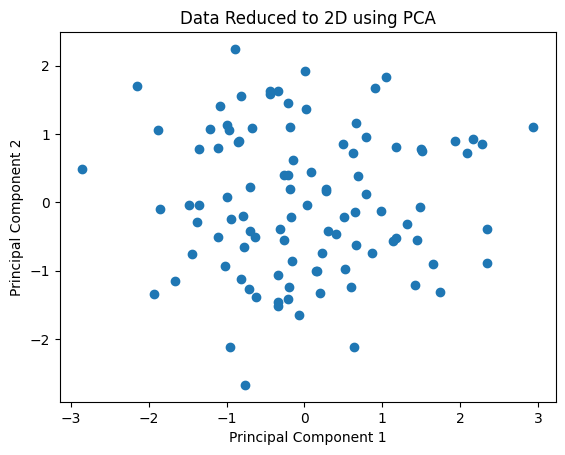

In [6]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Sample high-dimensional data (e.g., 5 features)
X_original = np.random.rand(100, 5) * [10, 1, 50, 20, 5] # Create some scale difference

# 2. Preprocess: Scale the data (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)

# 3. Instantiate and fit PCA
# We want to reduce from 5 dimensions to 2 for visualization
pca = PCA(n_components=2)
pca.fit(X_scaled)

# 4. Check the explained variance ratio
# This tells us how much information (variance) each principal component captures
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by component 1: {explained_variance[0]:.4f}")
print(f"Explained variance by component 2: {explained_variance[1]:.4f}")
print(f"Total variance explained by 2 components: {np.sum(explained_variance):.4f}")

# 5. Transform the data to the new 2D space
X_reduced = pca.transform(X_scaled)

print(f"\nOriginal data shape: {X_original.shape}")
print(f"Reduced data shape: {X_reduced.shape}")

# Now you could plot X_reduced on a 2D scatter plot
import matplotlib.pyplot as plt
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Data Reduced to 2D using PCA")
plt.show()